In [ ]:
!pip install nltk
!pip install matplotlib


In [ ]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import re
from collections import Counter
from nltk.tag import pos_tag, pos_tag_sents
from nltk.tokenize import word_tokenize
from nltk.tag.mapping import tagset_mapping
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.svm import SVC
from sklearn.metrics import f1_score, ConfusionMatrixDisplay

nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('tagsets')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.


True

In [ ]:
train_set = pd.read_csv('pan2425_train_data.csv', header=0, names=['snippet_id', 'text', 'author'], dtype={'author':str})
test_set = pd.read_csv('pan2425_test_data.csv', header=0, names=['snippet_id', 'text', 'author'], dtype={'author':str})
dev_set = pd.read_csv('pan2425_dev_data.csv', header=0, names=['snippet_id', 'text', 'author'], dtype={'author':str})

In [ ]:
train_set

,snippet_id,text,author
0,1798,"My legs were a bit shaky, so he wrapped an arm...",748687
1,1549,But... he looks so peaceful and... and... cute...,2750536
2,3011,"Wouldn""t want somebody thinking all of it was ...",583064
3,69,"""I..."" I chewed on my lip, feeling nervous mys...",748687
4,2722,"Eren sputtered, unable to move. Levi walked to...",2750536
...,...,...,...
2133,2115,He takes a deep breath and starts flapping his...,1276465
2134,1309,"The screen changed once more, and this time th...",806976
2135,1362,Down-he was most likely going to lose Pucca to...,3439302
2136,1596,"You are being stupid"" A hard wind blew again.....",29783


In [ ]:
pos_tags = ['CC','CD','DT','EX','FW','IN','JJ','JJR','JJS','LS','MD','NN','NNS','NNP','NNPS','PDT','POS','PRP','PRP$','RB','RBR','RBS','RP','SYM','TO','UH','VB','VBD','VBG','VBN','VBP','VBZ','WDT','WP','WP$','WRB']

In [ ]:
function_words = ['a','between','in','nor','some','upon','about','both','including','nothing','somebody','us','above','but','inside','of','someone','used','after','by','into','off','something','via','all','can','is','on','such','we','although','cos','it','once','than','what','am','do','its','one','that','whatever','among','down','latter','onto','the','when','an','each','less','opposite','their','where','and','either','like','or','them','whether','another','enough','little','our','these','which','any','every','lots','outside','they','while','anybody','everybody','many','over','this','who','anyone','everyone','me','own','those','whoever','anything','everything','more','past','though','whom','are','few','most','per','through','whose','around','following','much','plenty','till','will','as','for','must','plus','to','with','at','from','my','regarding','toward','within','be','have','near','same','towards','without','because','he','need','several','under','worth','before','her','neither','she','unless','would','behind','him','no','should','unlike','yes','below','i','nobody','since','until','you','beside','if','none','so','up','your']

## Feature extraction

In [ ]:
def characters_count(texts):
    return map(lambda text: len(text), texts)

def sentences_count(texts):
    return map(lambda text: len(re.split(r'[\.\!\?\;\:]+ [A-Z]', text)), texts)

def tokens_count(texts):
    return map(lambda text: len(text.split()), texts)

def words_without_vowels_count(texts):
    return map(lambda text: len(re.findall(r'\b[^aeiou\s]+\b', text)), texts)

def punctuation_count(texts):
    return map(lambda text: len(re.findall(r'[\.\,\;\:\!\?]', text)), texts)

def continuous_punctuation_count(texts):
    return map(lambda text: len(re.findall(r'[\.\!\?]{2,}', text)), texts)

def all_caps_words_count(texts):
    return map(lambda text: len(re.findall(r'[A-Z]{2,}\b', text)), texts)

def pos_tags_count(texts):
    return map(lambda text: Counter([tag_pair[1] for tag_pair in pos_tag(word_tokenize(text))]), texts)

def function_words_count(texts):
    return map(lambda text: Counter(text.lower().split()), texts)

def extract_features(texts):
    features = pd.DataFrame()
    features['characters_count'] = pd.Series(characters_count(texts))
    features['sentences_count'] = pd.Series(sentences_count(texts))
    features['tokens_count'] = pd.Series(tokens_count(texts))
    features['words_without_vowels_count'] = pd.Series(words_without_vowels_count(texts))
    features['punctuation_count'] = pd.Series(punctuation_count(texts))
    features['continuous_punctuation_count'] = pd.Series(continuous_punctuation_count(texts))
    features['all_caps_words_count'] = pd.Series(all_caps_words_count(texts))
    pos_tags_counts = pos_tags_count(texts)
    function_words_counts = function_words_count(texts)
    pos_tags_counts_columns = {tag+'_count':[] for tag in pos_tags}
    function_words_counts_columns = {function_word+'_count':[] for function_word in function_words}
    for text_pos_tags_counts, text_function_words_counts in zip(pos_tags_counts, function_words_counts):
        for tag in pos_tags:
            pos_tags_counts_columns[tag+'_count'].append(text_pos_tags_counts.get(tag, 0))
        for function_word in function_words:
            function_words_counts_columns[function_word+'_count'].append(text_function_words_counts.get(function_word, 0))
    features = pd.concat([features, pd.DataFrame(pos_tags_counts_columns, index=features.index)], axis=1)
    return pd.concat([features, pd.DataFrame(function_words_counts_columns, index=features.index)], axis=1)

In [ ]:
features_train = extract_features(train_set['text'])
features_train

,characters_count,sentences_count,tokens_count,words_without_vowels_count,punctuation_count,continuous_punctuation_count,all_caps_words_count,CC_count,CD_count,DT_count,...,nobody_count,since_count,until_count,you_count,beside_count,if_count,none_count,so_count,up_count,your_count
0,3038,36,551,54,115,6,0,23,1,33,...,0,0,0,5,0,2,0,4,1,0
1,3084,44,571,116,181,32,2,18,7,31,...,0,0,0,13,0,3,0,8,0,3
2,3039,26,545,34,100,10,1,16,3,40,...,0,0,0,4,0,4,0,0,2,0
3,3060,55,553,59,136,8,2,21,3,53,...,0,0,1,3,0,1,0,1,1,2
4,3081,30,537,44,131,13,0,10,15,38,...,0,0,0,6,0,4,0,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2133,3048,19,553,31,76,1,0,36,2,42,...,0,0,0,5,0,0,0,0,2,5
2134,3057,24,550,50,108,4,0,13,2,45,...,0,0,0,5,0,1,0,3,0,2
2135,3077,51,536,53,82,2,3,15,3,37,...,0,0,1,0,0,0,0,2,3,0
2136,2937,20,577,44,70,11,0,41,4,36,...,0,1,0,8,0,3,0,1,5,0


In [ ]:
features_dev = extract_features(dev_set['text'])

In [ ]:
scaler = MinMaxScaler()
classifier = SVC()
# classifier.fit(X=scaler.fit_transform(features_train.drop(columns=['characters_count'])), y=train_set['author'])

In [ ]:
y_dev_true = dev_set['author']
# y_dev_pred = classifier.predict(scaler.fit_transform(features_dev.drop(columns=['characters_count'])))
# f1_score(y_dev_true, y_dev_pred, average='micro')

In [ ]:
feature_groups = {
    "Character Count": ['characters_count'],
    "Sentence Count": ['sentences_count'],
    "Token Count": ['tokens_count'],
    "Words Without Vowels": ['words_without_vowels_count'],
    "Punctuation Count": ['punctuation_count'],
    "Continuous Punctuation Count": ['continuous_punctuation_count'],
    "All Caps Words Count": ['all_caps_words_count'],
    "POS Tags": [col for col in features_train.columns if col.endswith('_count') and col.split('_')[0] in pos_tags],
    "Function Words": [col for col in features_train.columns if col.endswith('_count') and col.split('_')[0] in function_words]
}

# scaler.fit(features_train)
X_train_scaled = scaler.fit_transform(features_train)
X_dev_scaled = scaler.fit_transform(features_dev)

In [ ]:
classifier = classifier.fit(X_train_scaled, train_set['author'])
baseline_f1 = f1_score(y_dev_true, classifier.predict(X_dev_scaled), average='micro')

print(f"Baseline F1 score: {baseline_f1}")

f1_scores = []
for group_name, group_features in feature_groups.items():
    reduced_features_train = features_train.drop(columns=group_features)
    reduced_features_dev = features_dev.drop(columns=group_features)

    X_train_reduced_scaled = scaler.fit_transform(reduced_features_train)
    X_dev_reduced_scaled = scaler.fit_transform(reduced_features_dev)
    classififer = classifier.fit(X_train_reduced_scaled, train_set['author'])

    y_dev_pred = classifier.predict(X_dev_reduced_scaled)
    score = f1_score(y_dev_true, y_dev_pred, average='micro')
    f1_scores.append(score)

group_names = list(feature_groups.keys())

print(f1_scores)

Baseline F1 score: 0.7686567164179104
[0.75, 0.746268656716418, 0.7649253731343284, 0.7686567164179104, 0.7761194029850746, 0.7611940298507462, 0.7723880597014925, 0.6604477611940298, 0.5783582089552238]


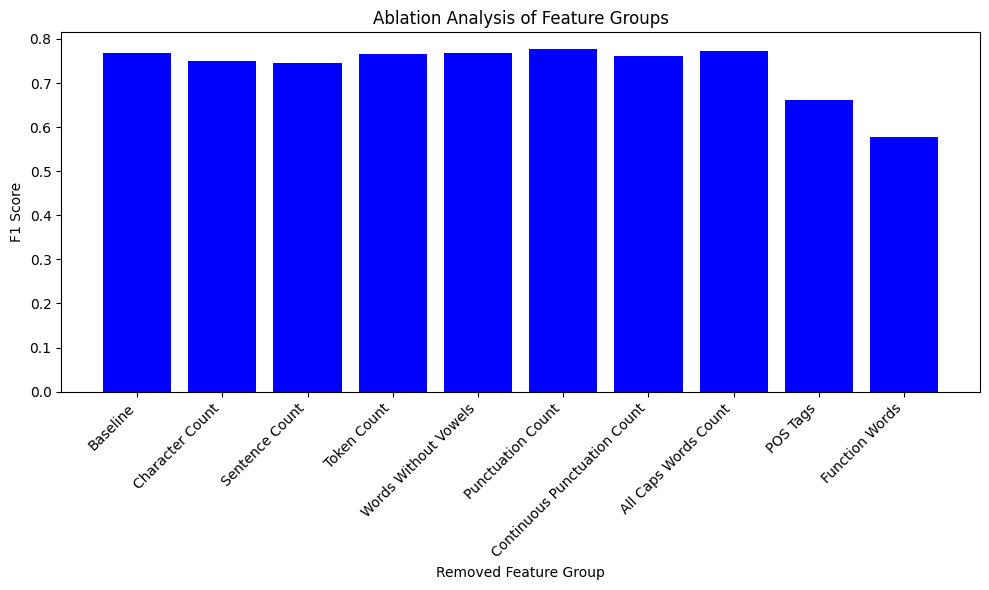

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(['Baseline']+group_names, [baseline_f1]+f1_scores, color='blue')
plt.xlabel("Removed Feature Group")
plt.ylabel("F1 Score")
plt.title("Ablation Analysis of Feature Groups")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

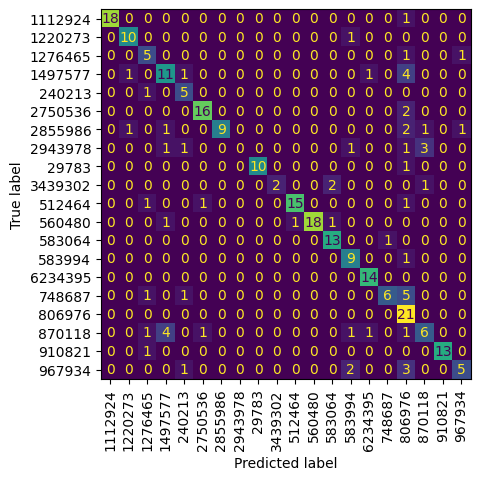

In [ ]:
ConfusionMatrixDisplay.from_estimator(classifier.fit(scaler.fit_transform(X_train_scaled), train_set['author']),
                                      X_dev_scaled, dev_set['author'], xticks_rotation='vertical', colorbar=False)

In [ ]:
test_features = extract_features(test_set['text'])

In [ ]:
classifier_baseline = classifier.fit(X_train_scaled, train_set['author'])
y_test_pred_baseline = classifier_baseline.predict(scaler.fit_transform(test_features))
f1_score(test_set['author'], y_test_pred_baseline, average='micro')

0.7340823970037453

In [ ]:
useless_features = ['characters_count','sentences_count','tokens_count','words_without_vowels_count','punctuation_count','continuous_punctuation_count','all_caps_words_count']
pos_and_function_words_features_train = scaler.fit_transform(features_train.drop(columns=useless_features))
pos_and_function_words_features_dev = scaler.fit_transform(features_dev.drop(columns=useless_features))

In [ ]:
classifier_pos_function_words = classifier.fit(pos_and_function_words_features_train, train_set['author'])
y_pred = classifier.predict(pos_and_function_words_features_dev)
f1_score(dev_set['author'], y_pred, average='micro')

0.7126865671641791

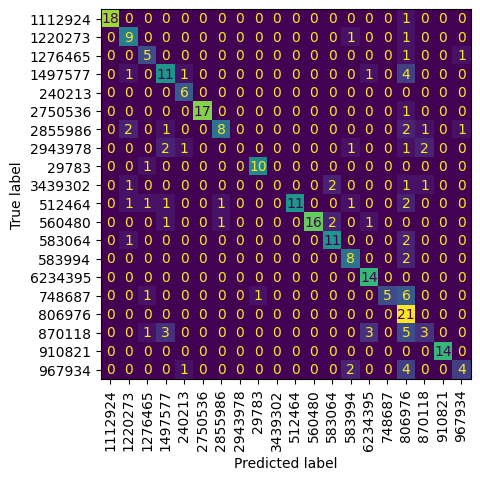

In [ ]:
ConfusionMatrixDisplay.from_estimator(classifier_pos_function_words, pos_and_function_words_features_dev,dev_set['author'], xticks_rotation='vertical', colorbar=False)

In [ ]:
y_test_pred_pos_function_words = classifier_pos_function_words.predict(scaler.fit_transform(test_features.drop(columns=useless_features)))
f1_score(test_set['author'], y_test_pred_pos_function_words, average='micro')

0.6741573033707865

In [ ]:
train_set.groupby('author').count()

,snippet_id,text
author,,
1112924,93,93
1220273,100,100
1276465,121,121
1497577,109,109
240213,98,98
2750536,132,132
2855986,117,117
2943978,51,51
29783,91,91
